In [1]:
%cd ..

/mnt/c/Users/XCB/OneDrive - Van Oord/Documents/thesis/code


In [61]:
import h5py
import xarray as xr
import geopandas as gpd
import pandas as pd
from glob import glob
import numpy as np

In [4]:
h5file = "../data/test_sites/florida_keys/ATL13/processed_ATL13_20190307091245_10530201_005_01.h5"

In [5]:
f.keys()

<KeysViewHDF5 ['METADATA', 'gt1r', 'gt2l', 'gt2r', 'gt3r']>

In [6]:
metadata = f["METADATA"]
metadata.keys()

<KeysViewHDF5 ['AcquisitionInformation', 'DataQuality', 'DatasetIdentification', 'Extent', 'Lineage', 'ProcessStep', 'ProductSpecificationDocument', 'QADatasetIdentification', 'SeriesIdentification']>

In [90]:
dflist = []
for filename in glob("../data/test_sites/florida_keys/ATL13/*.h5"):
    f = h5py.File(filename, "r")
    for beam in f.keys():
        if beam == "METADATA":
            continue
        df = xr.open_dataset(filename, group=f"/{beam}/").to_pandas()
        df["beam"] = beam
        dflist.append(df)

In [299]:
trackline_data = pd.read_pickle("notebooks/all_tracklines.pkl")
trackline_data = trackline_data[trackline_data.site == "florida_keys"]

In [313]:
df_atl13 = pd.concat(dflist).sort_index()
df_atl13["qf_subsurf_anomaly"] = df_atl13.qf_subsurf_anomaly.replace(np.NaN, 4)
df_atl13["date"] = pd.to_datetime(df_atl13.index).date

In [353]:
trackline_data.groupby(trackline_data["n bathy points"] > 10).mean()

,n_photons,p_hconf,avg_ph_cou,avg_fsat,length,RMS Error [m],MAE [m],Mean Error [M],n bathy points,zsd,sigma_zsd,diff_atten,diff_atten_unc,X,Y,gebco_elev,ph_per_m
n bathy points,,,,,,,,,,,,,,,,,
False,61409.825000,32.265396,132.773586,0.076306,15038.998331,2.207839,2.183817,-1.303748,0.500000,8.266087,54.744248,0.105442,71.828748,-81.022491,24.731755,-3.975000,3.881800
True,41266.990196,83.478465,66.718132,0.013039,16035.313220,0.609389,0.510821,0.354727,2560.372549,8.324620,57.564067,0.108199,74.982253,-80.987143,24.745629,-3.784314,2.534037


<AxesSubplot:xlabel='n bathy points', ylabel='RMS Error [m]'>

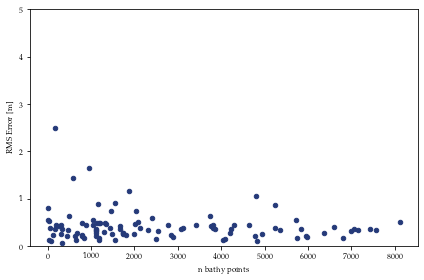

In [332]:
trackline_data.plot.scatter(x="n bathy points", y="RMS Error [m]", ylim=(0, 5))

In [346]:
atl13_plus_transect_data = df_atl13.merge(trackline_data, on=["date", "beam"])
atl13_plus_transect_data.groupby(atl13_plus_transect_data["n bathy points"] > 10).mean()

,qf_subsurf_anomaly,subsurface_attenuation,water_depth,n_photons,p_hconf,avg_ph_cou,avg_fsat,length,RMS Error [m],MAE [m],Mean Error [M],n bathy points,zsd,sigma_zsd,diff_atten,diff_atten_unc,X,Y,gebco_elev,ph_per_m
n bathy points,,,,,,,,,,,,,,,,,,,,
False,2.426881,0.423108,4.561790,201908.064985,52.299165,304.184206,0.356952,16189.126245,0.791960,0.791305,0.791305,0.463506,8.615457,53.475872,0.095787,70.833848,-81.034515,24.726682,-3.696868,12.511193
True,2.458652,0.150320,5.401643,81667.122911,86.149216,129.296601,0.025465,16641.100978,0.420695,0.361017,0.301888,3412.253143,8.541347,57.602960,0.104853,75.449923,-80.996461,24.741290,-3.771974,4.917225


<AxesSubplot:xlabel='subsurface_attenuation', ylabel='MAE [m]'>

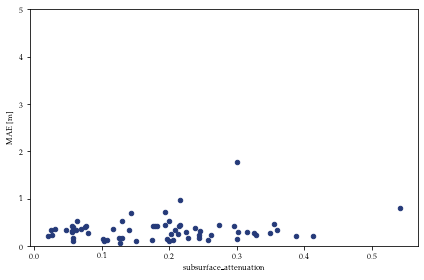

In [356]:
atl13_plus_transect_data.groupby(["date", "beam"]).mean().plot.scatter(
    x="subsurface_attenuation", y="MAE [m]", ylim=(0, 5)
)

In [323]:
df_atl13.set_index(["date", "beam"])

qf_subsurf_anomaly  subsurface_attenuation  water_depth
date       beam                                                         
2018-12-06 gt3l                 3.0                    0.02     7.507679
           gt2l                 2.0                    0.02     7.344579
           gt3l                 3.0                    0.02     7.507679
           gt2l                 2.0                    0.02     7.344579
           gt2l                 2.0                    0.02     7.344579
...                             ...                     ...          ...
2022-03-30 gt1r                 4.0                    0.34          NaN
           gt2r                 4.0                    0.40          NaN
           gt1r                 4.0                    0.34          NaN
           gt1r                 4.0                    0.34          NaN
           gt1r                 4.0                    0.34          NaN

[41698 rows x 3 columns]

In [94]:
df = gpd.read_file("../data/test_sites/florida_keys/all_bathy_pts.gpkg")
df = df.set_index(pd.to_datetime(df.delta_time))
df = df[~df.index.isna()]
df = df.sort_index()

In [270]:
mergedf = pd.merge_asof(
    df,
    df_atl13,
    left_index=True,
    right_index=True,
    direction="nearest",
    tolerance=pd.to_timedelta("100ms"),
    by="beam",
)
# .dropna()
mergedf["water_depth"] = mergedf.water_depth * -1
mergedf["qf_subsurf_anomaly"] = mergedf.qf_subsurf_anomaly.replace(np.NaN, -1)

In [271]:
mergedf

,X,Y,Z_ellip,Z_geoid,geoid_corr,tide_ocean_corr,geof2m_corr,delta_time,oc_sig_conf,land_sig_conf,...,easting_raw,northing_raw,sf_elev_MSL,true_elevation,error,error_abs,geometry,qf_subsurf_anomaly,subsurface_attenuation,water_depth
delta_time,,,,,,,,,,,,,,,,,,,,,
2018-10-17 08:53:07.355000,-80.872319,24.849378,-27.377422,-2.826529,-24.611639,0.119810,0.060746,2018-10-17T08:53:07.355000,4,4,...,512899.959565,2.748276e+06,-1.858880,-1.562335,0.296545,0.296545,POINT (512899.957 2748275.785),-1.0,NaN,NaN
2018-10-17 08:53:07.355000,-80.872320,24.849365,-27.393431,-2.842537,-24.611639,0.119810,0.060746,2018-10-17T08:53:07.355000,4,4,...,512899.824163,2.748274e+06,-1.858880,-1.542770,0.316111,0.316111,POINT (512899.822 2748274.364),-1.0,NaN,NaN
2018-10-17 08:53:07.356000,-80.872327,24.849295,-27.366703,-2.815809,-24.611639,0.119810,0.060746,2018-10-17T08:53:07.356000,4,4,...,512899.078882,2.748267e+06,-1.858880,-1.573890,0.284990,0.284990,POINT (512899.077 2748266.553),-1.0,NaN,NaN
2018-10-17 08:53:07.358000,-80.872342,24.849160,-27.013760,-2.463146,-24.611361,0.119829,0.060746,2018-10-17T08:53:07.358000,4,4,...,512897.652904,2.748252e+06,-1.828670,-1.618888,0.209781,0.209781,POINT (512897.651 2748251.636),-1.0,NaN,NaN
2018-10-17 08:53:07.358000,-80.872343,24.849147,-28.673019,-4.122406,-24.611361,0.119829,0.060746,2018-10-17T08:53:07.358000,4,3,...,512897.518472,2.748250e+06,-1.828670,-1.599680,0.228990,0.228990,POINT (512897.515 2748250.215),-1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31 05:39:51.634998,-81.115443,24.644570,-57.382660,-33.287251,-24.157200,0.023424,0.061791,2022-05-31T05:39:51.634998,0,0,...,488317.387845,2.725597e+06,-5.124672,-10.172050,-5.047379,5.047379,POINT (488317.740 2725597.265),-1.0,NaN,NaN
2022-05-31 05:39:51.648998,-81.115528,24.645449,-32.081085,-7.987160,-24.155714,0.023958,0.061788,2022-05-31T05:39:51.648998,1,2,...,488308.893416,2.725695e+06,-5.103587,-10.558483,-5.454896,5.454896,POINT (488308.977 2725694.609),-1.0,NaN,NaN
2022-05-31 05:39:51.648998,-81.115533,24.645493,-38.599472,-14.506044,-24.155214,0.024136,0.061787,2022-05-31T05:39:51.648998,1,0,...,488308.356859,2.725700e+06,-5.103409,-10.620831,-5.517422,5.517422,POINT (488308.510 2725699.547),-1.0,NaN,NaN


<AxesSubplot:xlabel='sf_elev_MSL', ylabel='water_depth'>

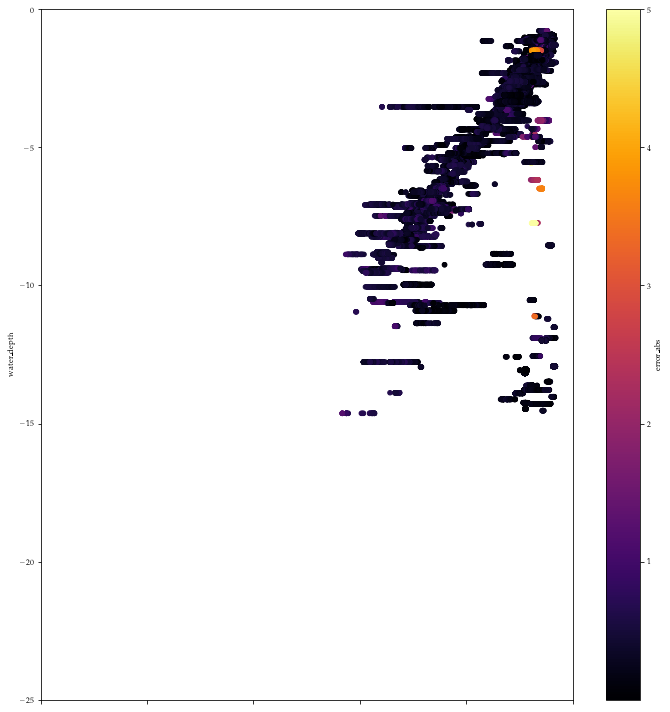

In [272]:
mergedf.plot.scatter(
    x="sf_elev_MSL",
    y="water_depth",
    figsize=(10, 10),
    xlim=(-25, 0),
    ylim=(-25, 0),
    c="error_abs",
    cmap="inferno",
    vmax=5,
)

In [273]:
mergedf.groupby("qf_subsurf_anomaly").mean().error_abs

qf_subsurf_anomaly
-1.0    0.340525
 1.0    0.279045
 2.0    0.283916
 3.0    0.292562
Name: error_abs, dtype: float64

In [274]:
nona = mergedf.dropna()

In [275]:
from sklearn.metrics import mean_squared_error

In [276]:
pts_w_validation_data = df.dropna()
mean_squared_error(
    pts_w_validation_data.true_elevation, pts_w_validation_data.sf_elev_MSL
)

0.6860460531161905

In [277]:
mean_squared_error(nona.true_elevation, nona.sf_elev_MSL)

0.1951020572919627

In [260]:
mean_squared_error(nona.true_elevation, nona.water_depth)

6.003736587051954

In [261]:
mean_squared_error(nona.sf_elev_MSL, nona.water_depth)

5.932658645653391

<AxesSubplot:xlabel='subsurface_attenuation'>

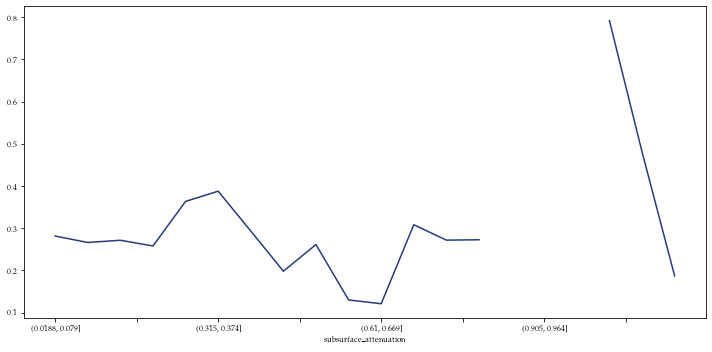

In [282]:
mergedf.groupby(pd.cut(mergedf.subsurface_attenuation, 20)).mean().error_abs.plot(
    figsize=(10, 5)
)

<AxesSubplot:xlabel='subsurface_attenuation', ylabel='error_abs'>

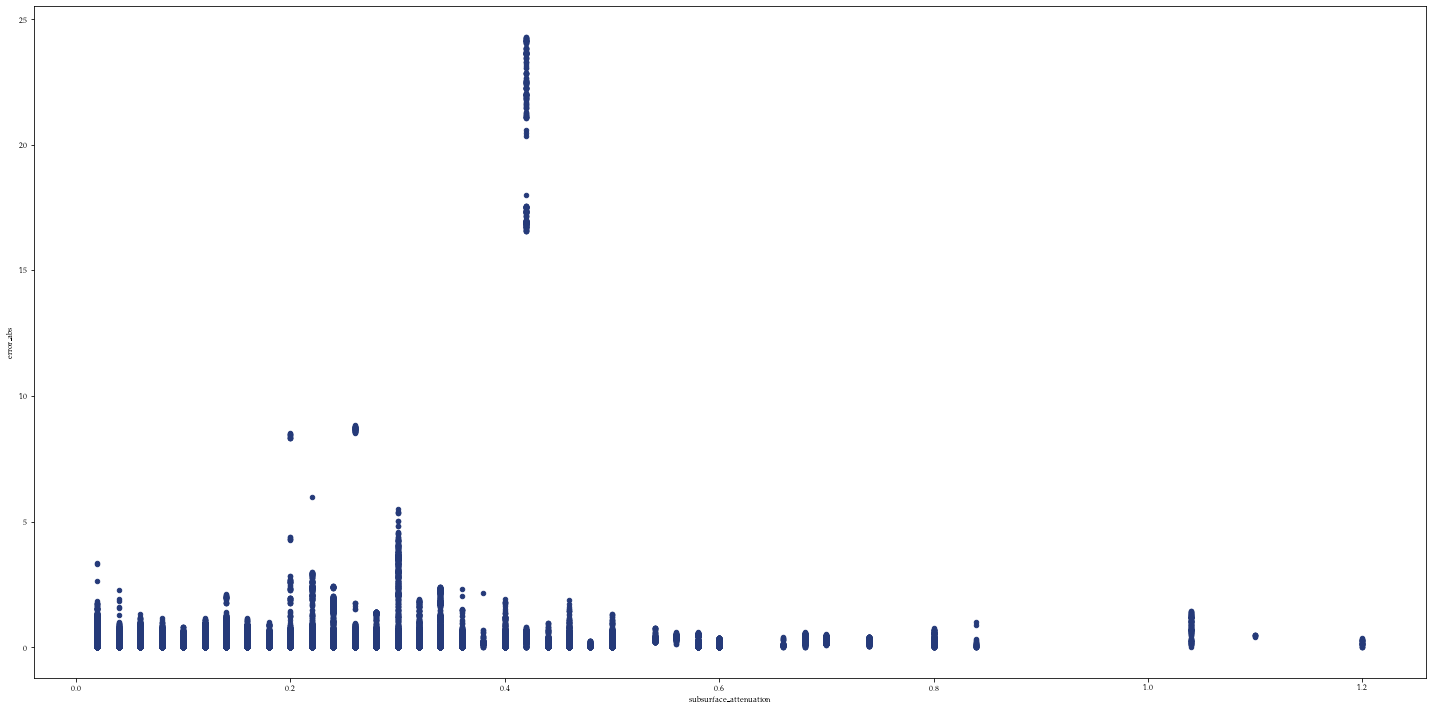

In [263]:
mergedf.plot.scatter(x="subsurface_attenuation", y="error_abs", figsize=(20, 10))

<AxesSubplot:xlabel='true_elevation', ylabel='water_depth'>

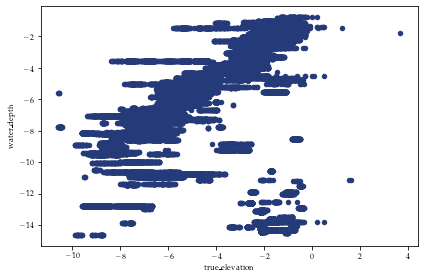

In [283]:
mergedf.plot.scatter(
    x="true_elevation",
    y="water_depth",
)

<AxesSubplot:>

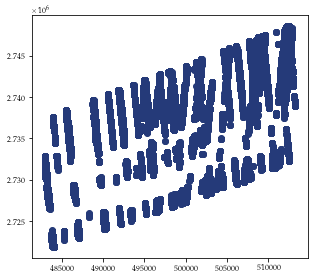

In [265]:
mergedf.plot()

<AxesSubplot:>

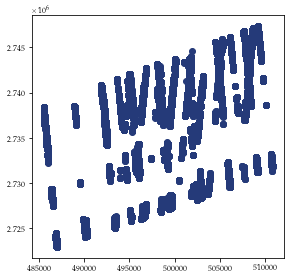

In [266]:
nona.plot()

In [267]:
df_atl13

,qf_subsurf_anomaly,subsurface_attenuation,water_depth,beam
delta_time,,,,
2018-12-06 18:22:02.350557008,3.0,0.02,7.507679,gt3l
2018-12-06 18:22:02.359456968,2.0,0.02,7.344579,gt2l
2018-12-06 18:22:02.377056996,3.0,0.02,7.507679,gt3l
2018-12-06 18:22:02.384956988,2.0,0.02,7.344579,gt2l
2018-12-06 18:22:02.401856988,2.0,0.02,7.344579,gt2l
...,...,...,...,...
2022-03-30 08:36:00.546029552,-1.0,0.34,NaN,gt1r
2022-03-30 08:36:00.573229536,-1.0,0.40,NaN,gt2r
2022-03-30 08:36:00.576429568,-1.0,0.34,NaN,gt1r


In [268]:
len(mergedf)

263577

In [269]:
mergedf[mergedf.subsurface_attenuation.isna()]

,X,Y,Z_ellip,Z_geoid,geoid_corr,tide_ocean_corr,geof2m_corr,delta_time,oc_sig_conf,land_sig_conf,...,easting_raw,northing_raw,sf_elev_MSL,true_elevation,error,error_abs,geometry,qf_subsurf_anomaly,subsurface_attenuation,water_depth
delta_time,,,,,,,,,,,,,,,,,,,,,
2018-10-17 08:53:07.355000,-80.872319,24.849378,-27.377422,-2.826529,-24.611639,0.119810,0.060746,2018-10-17T08:53:07.355000,4,4,...,512899.959565,2.748276e+06,-1.858880,-1.562335,0.296545,0.296545,POINT (512899.957 2748275.785),-1.0,NaN,NaN
2018-10-17 08:53:07.355000,-80.872320,24.849365,-27.393431,-2.842537,-24.611639,0.119810,0.060746,2018-10-17T08:53:07.355000,4,4,...,512899.824163,2.748274e+06,-1.858880,-1.542770,0.316111,0.316111,POINT (512899.822 2748274.364),-1.0,NaN,NaN
2018-10-17 08:53:07.356000,-80.872327,24.849295,-27.366703,-2.815809,-24.611639,0.119810,0.060746,2018-10-17T08:53:07.356000,4,4,...,512899.078882,2.748267e+06,-1.858880,-1.573890,0.284990,0.284990,POINT (512899.077 2748266.553),-1.0,NaN,NaN
2018-10-17 08:53:07.358000,-80.872342,24.849160,-27.013760,-2.463146,-24.611361,0.119829,0.060746,2018-10-17T08:53:07.358000,4,4,...,512897.652904,2.748252e+06,-1.828670,-1.618888,0.209781,0.209781,POINT (512897.651 2748251.636),-1.0,NaN,NaN
2018-10-17 08:53:07.358000,-80.872343,24.849147,-28.673019,-4.122406,-24.611361,0.119829,0.060746,2018-10-17T08:53:07.358000,4,3,...,512897.518472,2.748250e+06,-1.828670,-1.599680,0.228990,0.228990,POINT (512897.515 2748250.215),-1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31 05:39:51.634998,-81.115443,24.644570,-57.382660,-33.287251,-24.157200,0.023424,0.061791,2022-05-31T05:39:51.634998,0,0,...,488317.387845,2.725597e+06,-5.124672,-10.172050,-5.047379,5.047379,POINT (488317.740 2725597.265),-1.0,NaN,NaN
2022-05-31 05:39:51.648998,-81.115528,24.645449,-32.081085,-7.987160,-24.155714,0.023958,0.061788,2022-05-31T05:39:51.648998,1,2,...,488308.893416,2.725695e+06,-5.103587,-10.558483,-5.454896,5.454896,POINT (488308.977 2725694.609),-1.0,NaN,NaN
2022-05-31 05:39:51.648998,-81.115533,24.645493,-38.599472,-14.506044,-24.155214,0.024136,0.061787,2022-05-31T05:39:51.648998,1,0,...,488308.356859,2.725700e+06,-5.103409,-10.620831,-5.517422,5.517422,POINT (488308.510 2725699.547),-1.0,NaN,NaN
